## Business Understanding
Proyek ini bertujuan untuk mengembangkan sistem klasifikasi penyakit kulit menggunakan model Deep Learning, khususnya Convolutional Neural Network (CNN). Klasifikasi akan dilakukan berdasarkan gambar penyakit kulit seperti acne, vitiligo, hyperpigmentation, nail psoriasis, dan SJS-TEN. Hasilnya akan membantu dalam diagnosa awal penyakit kulit yang dapat diakses oleh masyarakat.

## Data Understanding
Pada tahap ini, kita melakukan pemahaman tentang dataset yang digunakan untuk model pelatihan. Dataset terdiri dari gambar-gambar yang dikelompokkan berdasarkan jenis penyakit kulit.

In [1]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

In [2]:
# Import Library dan Setup
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflowjs as tfjs

2025-05-27 11:43:28.154228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748346208.358757      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748346208.419539      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preparation
Pada tahap ini, kita akan mempersiapkan data untuk digunakan dalam pelatihan model, termasuk normalisasi gambar, augmentasi data, dan pembagian data menjadi set pelatihan, validasi, dan pengujian.

In [3]:
# Load dataset
dataset_dir = '/kaggle/input/dataset/skinDisease/'

In [4]:
# Define parameters
img_size = 224  # Ukuran gambar (resize gambar)
batch_size = 32  # Ukuran batch untuk training

In [5]:
# ImageDataGenerator setup for training, validation, and testing data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi gambar
    rotation_range=30,  # Rotasi gambar secara acak
    width_shift_range=0.2,  # Geser gambar secara horizontal
    height_shift_range=0.2,  # Geser gambar secara vertikal
    shear_range=0.2,  # Geser gambar secara shear
    zoom_range=0.2,  # Zoom gambar secara acak
    horizontal_flip=True,  # Flip gambar secara horizontal
    fill_mode='nearest',  # Isi ulang piksel yang hilang
    validation_split=0.2  # Membagi 20% data untuk validasi
)

In [6]:
# Just normalize the images for test
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Load the data using flow_from_directory to automatically label images based on folder names
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Gunakan 80% data untuk training
)

Found 4342 images belonging to 5 classes.


In [8]:
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Gunakan 20% data untuk validasi
)

Found 1083 images belonging to 5 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5425 images belonging to 5 classes.


## Modelling
Setelah persiapan data, kita membangun model CNN untuk melakukan klasifikasi gambar. Kemudian model dilatih menggunakan data pelatihan dan data validasi. Kita juga menggunakan ModelCheckpoint untuk menyimpan model terbaik berdasarkan performa pada data validasi.

In [10]:
model = Sequential()

In [11]:
# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748346227.899442      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748346227.900128      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [12]:
# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [13]:
# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [14]:
# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [15]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [17]:
history = model.fit(
    train_generator,
    epochs=50, 
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1748346233.069215     108 service.cc:148] XLA service 0x7a8f58004810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748346233.070112     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748346233.070139     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748346233.454631     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/136 ━━━━━━━━━━━━━━━━━━━━ 19:18 9s/step - accuracy: 0.2188 - loss: 1.6056

I0000 00:00:1748346238.770030     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.3548 - loss: 1.7064
Epoch 1: val_loss improved from inf to 1.36039, saving model to best_model.h5
136/136 ━━━━━━━━━━━━━━━━━━━━ 93s 626ms/step - accuracy: 0.3551 - loss: 1.7043 - val_accuracy: 0.4257 - val_loss: 1.3604
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.4765 - loss: 1.2402
Epoch 2: val_loss improved from 1.36039 to 1.31535, saving model to best_model.h5
136/136 ━━━━━━━━━━━━━━━━━━━━ 59s 434ms/step - accuracy: 0.4766 - loss: 1.2400 - val_accuracy: 0.4488 - val_loss: 1.3153
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.5323 - loss: 1.1557
Epoch 3: val_loss improved from 1.31535 to 1.22160, saving model to best_model.h5
136/136 ━━━━━━━━━━━━━━━━━━━━ 59s 436ms/step - accuracy: 0.5324 - loss: 1.1556 - val_accuracy: 0.4885 - val_loss: 1.2216
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.5661 - loss: 1.0883
Epoch 4: val_loss improved from 1.22160 to 1.09157, savin

## Evaluation
Setelah pelatihan selesai, kita evaluasi model menggunakan data pengujian untuk memastikan kinerjanya. Kemudian untuk memantau performa model selama pelatihan, kita dapat membuat grafik yang menunjukkan akurasi dan loss selama pelatihan dan validasi.

In [37]:
# Load the best model saved during training
best_model = load_model('best_model.h5')

In [38]:
# Evaluate the model on the test dataset
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

170/170 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.9053 - loss: 0.3097
Test Loss: 0.3129464089870453
Test Accuracy: 0.9028571248054504


In [39]:
# Visualize Training Results (Accuracy & Loss)
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

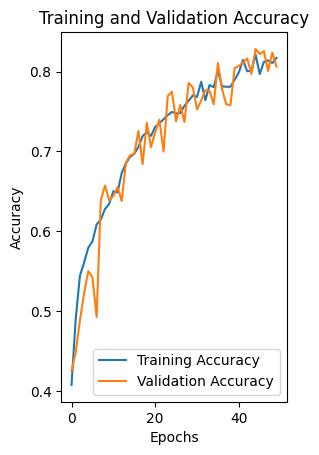

In [40]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

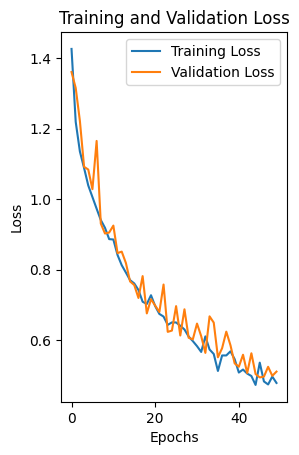

In [41]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Model Saving
Model terbaik disimpan dalam format .h5 untuk digunakan di backend atau konversi ke TensorFlow.js untuk frontend.

In [43]:
best_model.save('final_skin_disease_model.h5')  # Save model as .h5 file